In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### 1.Messages

In [3]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [AIMessage(content="Plz Tell me How can I Help", name="LLMModel")]
messages.append(HumanMessage(content="I want to Learn Coding", name="Husen"))
messages.append(AIMessage(content="Which Programming you want to Learn", name="LLMModel"))
messages.append(HumanMessage(content="I want to learn Python Programming Language", name="Husen"))

for message in messages:
    message.pretty_print()


================================== Ai Message ==================================
Name: LLMModel

Plz Tell me How can I Help
================================ Human Message =================================
Name: Husen

I want to Learn Coding
================================== Ai Message ==================================
Name: LLMModel

Which Programming you want to Learn
================================ Human Message =================================
Name: Husen

I want to learn Python Programming Language


### Chat Models

In [4]:
from langchain_groq import ChatGroq

model = ChatGroq(model = "llama-3.1-8b-instant")
result = model.invoke(messages)

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 514,
  'prompt_tokens': 76,
  'total_tokens': 590,
  'completion_time': 0.750983198,
  'completion_tokens_details': None,
  'prompt_time': 0.034535996,
  'prompt_tokens_details': None,
  'queue_time': 0.056604894,
  'total_time': 0.785519194},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_4387d3edbb',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

#### Creating a Tool

In [6]:
def add(a:int,b:int)->int:
    """Add a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: result
    """
    return a+b

### Binding tool with LLM

In [63]:
model_with_tool = model.bind_tools([add])
tool_call = model_with_tool.invoke([HumanMessage(content="What is 2+2",name="Husen")])

In [ ]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j1z09zegy', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 230, 'total_tokens': 248, 'completion_time': 0.030998379, 'completion_tokens_details': None, 'prompt_time': 0.033137652, 'prompt_tokens_details': None, 'queue_time': 0.050320737, 'total_time': 0.064136031}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b0d9d-d7ec-7b13-a200-af85530b82f6-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'j1z09zegy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 230, 'output_tokens': 18, 'total_tokens': 248})

#### Using Messages as State

In [66]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

#### Reducers with add_messages

In [67]:
initial_message = [AIMessage(content="Plz Tell me How can I Help", name="LLMModel")]
initial_message.append(HumanMessage(content="I want to Learn Coding", name="Husen"))
initial_message

[AIMessage(content='Plz Tell me How can I Help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to Learn Coding', additional_kwargs={}, response_metadata={}, name='Husen')]

In [68]:
ai_message =(AIMessage(content="Which Programming you want to Learn", name="LLMModel"))
ai_message

AIMessage(content='Which Programming you want to Learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

### Add the message in Reducers

In [69]:
#It append the Human message and ai message in list place called list
#It Only Append instead of Replace
add_messages(initial_message,ai_message)

[AIMessage(content='Plz Tell me How can I Help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='4cf0bf50-c6f1-47ac-af2e-4e6098b8c616'),
 HumanMessage(content='I want to Learn Coding', additional_kwargs={}, response_metadata={}, name='Husen', id='9352fb04-7951-4762-9ec0-deee90787807'),
 AIMessage(content='Which Programming you want to Learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='a4777f72-3416-4876-9598-3a480c183008')]

In [ ]:
### Tool Calling LLM
model_with_tool = model.bind_tools([add])

def llm_tool(state:State):
    return{"messages":[model_with_tool.invoke(state["messages"])]}

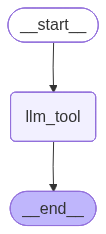

In [71]:
### Define the State Graph

from IPython.display import Image,display
from langgraph.graph import START,END,StateGraph

graph = StateGraph(State)

## Add Nodes
graph.add_node("llm_tool",llm_tool)

## Add Edges
graph.add_edge(START,"llm_tool")
graph.add_edge("llm_tool",END)

# Complie the Graph

graph_builder = graph.compile()

#Draw The Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [72]:
messages = graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (zbtzrfyjy)
 Call ID: zbtzrfyjy
  Args:
    a: 2
    b: 2


In [74]:
tools=[add]

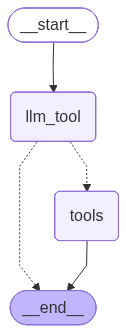

In [ ]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

#Define the Graph
graph = StateGraph(State)

#Add Nodes
graph.add_node("llm_tool",llm_tool)
graph.add_node("tools",ToolNode(tools))

#Add Edges
graph.add_edge(START,"llm_tool")
graph.add_conditional_edges("llm_tool",tools_condition)
graph.add_edge("tools",END)

#Compile the Graph
graph_builder = graph.compile()

#Draw the Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [76]:
messages = graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (2v5pgqzg9)
 Call ID: 2v5pgqzg9
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [77]:
messages = graph_builder.invoke({"messages":"What is Data Science"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is Data Science
================================== Ai Message ==================================

Data Science is a multidisciplinary field that uses scientific methods, processes, algorithms and systems to extract knowledge and insights from structured and unstructured data in various forms.
